<a href="https://colab.research.google.com/github/Miguel-Andrade-Cruz/Hackaton-dados-Py013-Mosten/blob/main/Hackathon_Py013_Mosten_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon Mosten 2025 - Transito em Santos

In [ ]:
from datetime import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt

INDEX_NEIGHBORHOOD = 7
INDEX_TRAFFIC_LIGHTS = 9
INDEX_ACCINDENT_DATE = 2
INDEX_ACCIDENT_TIME = 3
INDEX_ADDRESS = 4
INDEX_STREET_NUM = 5
INDEX_ACCIDENT_TYPE = 10

COLUMN_NEIGHBOURHOOD = 'Bairro'
COLUMN_TRAFFIC_LIGHTS = 'Condição semáfaros'
COLUMN_ACCINDENT_DATE = 'Data'
COLUMN_ACCIDENT_TIME = 'Horário'
COLUMN_ADDRESS = 'Logradouro'
COLUMN_STREET_NUM = 'Número rua'
COLUMN_ACCIDENT_TYPE = 'Tipo acidente'


## Usando requests

In [ ]:
url = "https://egov.santos.sp.gov.br/santosmapeada/CET/Acidente/Acidente/montarAcidenteRel"
payload = {
	"args[]": [
		"2025",
		"0",
		"0",
		"0",
		"0",
		"0",
		"0",
		"0",
		"0",
		"0",
		"0",
		"999",
		"0",
		"0",
		"0",
		"0",
		"0",
		"",
		"",
		"",
		""
	]
}


cookies =		{"PHPSESSID": "84b54d6b0f6bc2a43a98084be8d3ee2f"}


res = requests.post(
    url=url,
    data=payload,
    cookies=cookies
)


print(res)

<Response [200]>


## Dados para dataframe

In [ ]:
response = res.json()['aaData']
df_main = pd.DataFrame(response).drop_duplicates()

df_main.rename(
  columns={
    INDEX_NEIGHBORHOOD: COLUMN_NEIGHBOURHOOD,
    INDEX_ACCIDENT_TIME: COLUMN_ACCIDENT_TIME,
    INDEX_ACCINDENT_DATE: COLUMN_ACCINDENT_DATE,
    INDEX_ADDRESS: COLUMN_ADDRESS,
    INDEX_STREET_NUM: COLUMN_STREET_NUM,
    INDEX_ACCIDENT_TYPE: COLUMN_ACCIDENT_TYPE,
    INDEX_TRAFFIC_LIGHTS: COLUMN_TRAFFIC_LIGHTS
  },
  inplace=True)

df_clean = df_main[[
    COLUMN_NEIGHBOURHOOD,
    COLUMN_ACCIDENT_TIME,
    COLUMN_ACCINDENT_DATE,
    COLUMN_ADDRESS,
    COLUMN_STREET_NUM,
    COLUMN_ACCIDENT_TYPE,
    COLUMN_TRAFFIC_LIGHTS
]]

df_clean.sample(3).T

,105,654,531
Bairro,Saboó,Pompéia,Gonzaga
Horário,18:44:00,19:55:00,14:05:00
Data,12/03/2025,06/01/2025,11/01/2025
Logradouro,Avenida Martins Fontes,Avenida Presidente Wilson,Avenida Vicente de Carvalho
Número rua,0,94,27
Tipo acidente,COLISÃO,COLISÃO,ABALROAMENTO
Condição semáfaros,INEXISTENTE,INEXISTENTE,INEXISTENTE


## Tipos de acidentes

<Axes: xlabel='Tipo acidente,Bairro'>

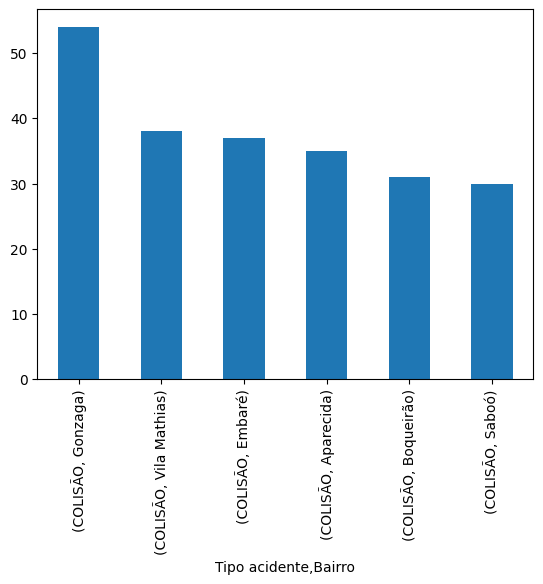

In [ ]:
tipo_acidente_por_bairro = df_clean[[COLUMN_ACCIDENT_TYPE, COLUMN_NEIGHBOURHOOD]].copy().value_counts()
tipo_acidente_por_bairro.head(6).plot.bar()

## Bairros e condição de semáforo

## Ruas principais

<Axes: xlabel='Logradouro,Condição semáfaros'>

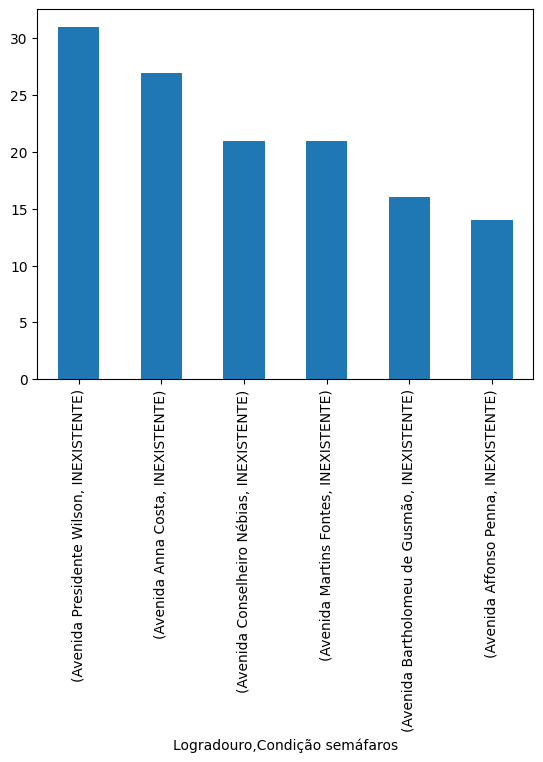

In [ ]:
acidentes_condicao_semafaro_bairros = df_clean[[COLUMN_ADDRESS, COLUMN_TRAFFIC_LIGHTS]].copy().value_counts()
acidentes_condicao_semafaro_bairros.head(6).plot.bar()

## Numeração (0 é usado no dataset para encruzilhadas)

<Axes: title={'center': 'Localidade (na rua) dos acidentes'}, ylabel='count'>

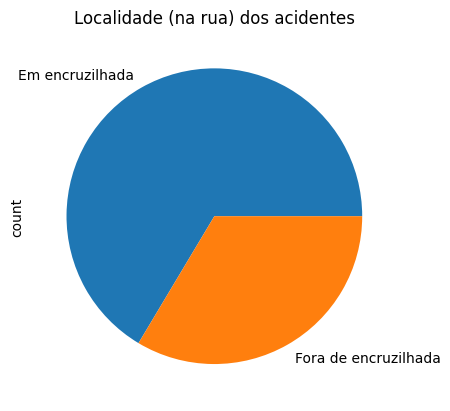

In [ ]:
acidentes_localizacao = df_clean[COLUMN_STREET_NUM].copy()

acidentes_categorizados = acidentes_localizacao.apply(
    lambda street_no: 'Em encruzilhada' if street_no == '0' else 'Fora de encruzilhada'
)
acidentes_categorizados.value_counts().head().plot(title='Localidade (na rua) dos acidentes', kind='pie')

<Axes: xlabel='Hora,Hora'>

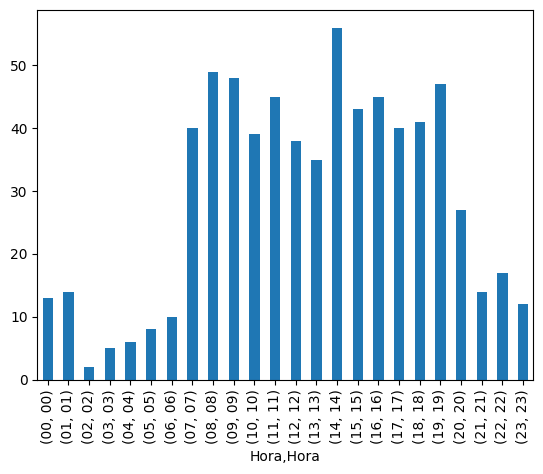

In [ ]:
COLUMN_HOUR = 'Hora'

acidentes_bairro = df_clean[COLUMN_NEIGHBOURHOOD].copy()
acidentes_data_hora = df_clean[[COLUMN_ACCINDENT_DATE, COLUMN_ACCIDENT_TIME]].copy()

acidentes_data_hora[COLUMN_HOUR] = acidentes_data_hora[COLUMN_ACCINDENT_DATE] + acidentes_data_hora[COLUMN_ACCIDENT_TIME]
acidentes_hora = acidentes_data_hora[COLUMN_HOUR]

def groupByHour(date_and_time):
  date_time_obj = datetime.strptime(date_and_time, "%d/%m/%Y%H:%M:%S")
  hour = date_time_obj.strftime("%H")
  return hour

timestamps = acidentes_hora.apply(groupByHour)

acidentes_categorizado = timestamps.groupby(timestamps)
acidentes_categorizado.value_counts().plot.bar()



In [ ]:
# Usando timestamps e acidentes_bairro da célula anterior

horarios_de_pico = ['07', '08', '14', '19']

acidentes_bairro_horario = pd.DataFrame({COLUMN_NEIGHBOURHOOD: acidentes_bairro, COLUMN_HOUR: timestamps})
acidentes_bairro_horario_pico = acidentes_bairro_horario[acidentes_bairro_horario[COLUMN_HOUR].isin(horarios_de_pico)]

acidentes_bairro_horario_pico = acidentes_bairro_horario_pico.groupby(COLUMN_NEIGHBOURHOOD, as_index=False).value_counts()

acidentes_bairro_horario_pico = acidentes_bairro_horario_pico.pivot_table(columns=COLUMN_NEIGHBOURHOOD, index=COLUMN_HOUR, values='count').fillna(0)


<Axes: title={'center': 'Bairros próximos da praia'}, xlabel='Hora'>

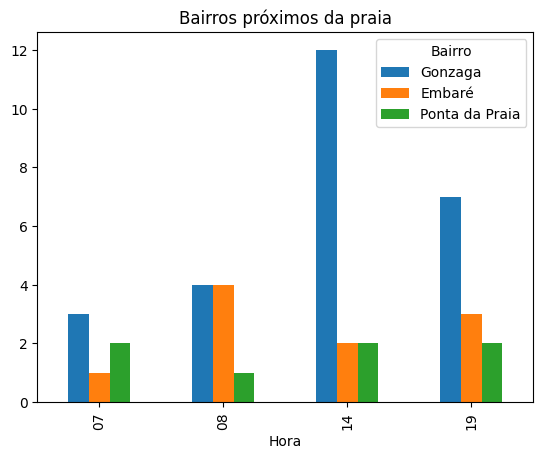

In [ ]:
# Usando última varáivel da célula acima

bairros_praia = acidentes_bairro_horario_pico[['Gonzaga', 'Embaré', 'Ponta da Praia']]

bairros_praia.plot(title='Bairros próximos da praia', kind='bar')

<Axes: title={'center': 'Bairros próximos da Zona Noroeste'}, xlabel='Hora'>

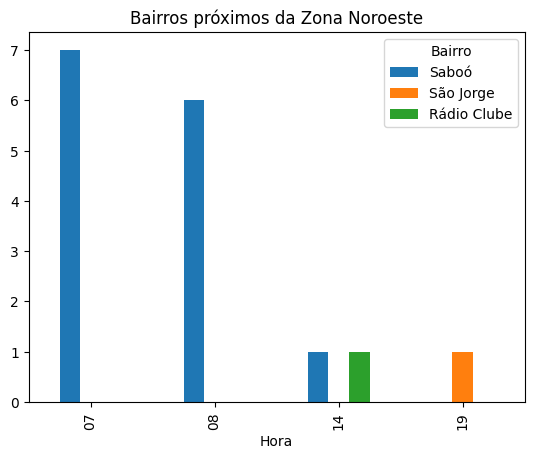

In [ ]:
bairros_zn = acidentes_bairro_horario_pico[['Saboó', 'São Jorge', 'Rádio Clube']]
bairros_zn.plot(title='Bairros próximos da Zona Noroeste', kind='bar')